In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
from numpy import pi

In [2]:
# CC nadapez: from https://stackoverflow.com/a/20958684
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + pi)  / (2 * pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Scalable Angular Spectrum Method

General hint, we assume the array to be three dimensional. The first dimension is a batch dimension.


## License
If you copy this code, include this LICENSE statement:


MIT License. Copyright (c) 2023 Felix Wechsler (info@felixwechsler.science), Rainer Heintzmann, Lars Lötgering

In [4]:
def zero_pad(arr, device=device):
    out_arr = torch.zeros(arr.shape[0], arr.shape[1] * 2, arr.shape[2] * 2, device=device, dtype=arr.dtype)
    
    as1 = (arr.shape[1] + 1) // 2
    as2 = (arr.shape[2] + 1) // 2
    out_arr[:, as1:as1 + arr.shape[1], as2:as2 + arr.shape[2]] = arr
    return out_arr

def zero_unpad(arr, original_shape):
        
    as1 = (original_shape[1] + 1) // 2
    as2 = (original_shape[2] + 1) // 2
    return arr[:, as1:as1 + original_shape[1], as2:as2 + original_shape[2]]


In [5]:
def scalable_angular_spectrum(psi, z, lbd, L, device=device):
    N = psi.shape[-1]
    z_limit = (- 4 * L * np.sqrt(8*L**2 / N**2 + lbd**2) * np.sqrt(L**2 * 1 / (8 * L**2 + N**2 * lbd**2))\
               / (lbd * (-1+2 * np.sqrt(2) * np.sqrt(L**2 * 1 / (8 * L**2 + N**2 * lbd**2)))))
    
    assert z <= z_limit
    
    
    # don't change this pad_factor, only 2 is supported
    pad_factor = 2
    L_new = pad_factor * L
    N_new = pad_factor * N
    # pad array
    M = lbd * z * N / L**2 / 2
    psi_p = zero_pad(psi)
    
    # helper varaibles
    k = 2 * torch.pi / lbd
    df = 1 / L_new 
    Lf = N_new * df
    
    # freq space coordinates for padded array
    f_y = torch.fft.fftfreq(N_new, 1 / Lf).reshape(1,1, N_new).to(device).type(torch.float32)
    f_x = f_y.reshape(1, N_new, 1)
    
    # real space coordinates for padded array
    y = torch.fft.ifftshift(torch.tensor(np.linspace(-L_new/2, L_new/2, N_new, endpoint=False),
                               device=device).reshape(1, 1, N_new), dim=(-1))
    x = y.reshape(1, N_new, 1)
    
    # bandlimit helper
    cx = lbd * f_x 
    cy = lbd * f_y 
    tx = L_new / 2 / z + torch.abs(lbd * f_x)
    ty = L_new / 2 / z + torch.abs(lbd * f_y)
   
    # bandlimit filter for precompensation, not smoothened!
    W = (cx**2 * (1 + tx**2) / tx**2 + cy**2 <= 1) * (cy**2 * (1 + ty**2) / ty**2 + cx**2 <= 1)
    
    # calculate kernels
    H_AS = torch.sqrt(0j + 1 - torch.abs(f_x * lbd)**2 - torch.abs(f_y * lbd)**2)
    H_Fr = 1 - torch.abs(f_x * lbd)**2 / 2 - torch.abs(f_y * lbd)**2 / 2
    delta_H = W * torch.exp(1j * k * z * (H_AS - H_Fr))

    # apply precompensation
    psi_precomp = torch.fft.ifft2(torch.fft.fft2(torch.fft.ifftshift(psi_p, dim=(-1, -2)))\
                                  * delta_H)
    # output coordinates
    dq = lbd * z / L_new
    Q = dq * N * pad_factor
    
    
    # skip final H_2 phase
    H_1 = torch.exp(1j * k / (2 * z) * (x**2 + y**2))
    psi_p_final = torch.fft.fftshift(torch.fft.fft2(H_1 * psi_precomp), dim=(-1,-2))

    psi_final = zero_unpad(psi_p_final, psi.shape)
    
    return psi_final, Q 


In [6]:
L_box = 128e-6
D_box = L_box / 16
N_box = 512;
lbd = 500e-9
y_box = torch.tensor(np.linspace(-L_box/2, L_box/2, N_box, endpoint=False), device=device).reshape(1,1, N_box)
x_box = y_box.reshape(1, N_box, 1)

U_box = ((x_box)**2 <= (D_box / 2)**2) * (y_box**2 <= (D_box / 2)**2) *\
        (torch.exp(1j * 2 * torch.pi / lbd * y_box * np.sin(20/ 360 * 2 * torch.pi)))
                                                                                
M_box = 8;          
z_box = M_box / N_box / lbd * L_box**2 * 2                                                                     
U_prop, Q = scalable_angular_spectrum(U_box, z_box, lbd, L_box)

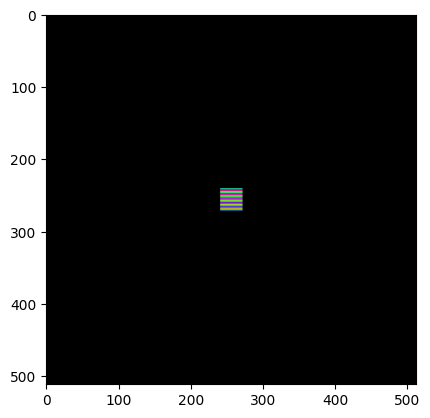

In [7]:
plt.imshow(colorize(U_box[0,...].cpu().cpu().numpy()))

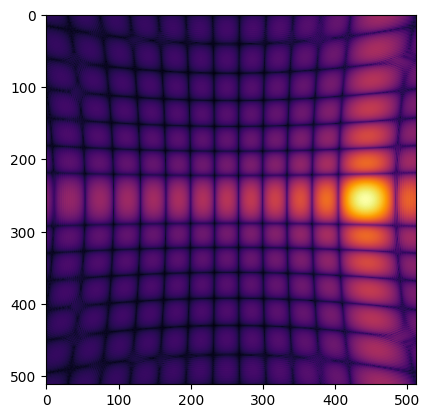

In [8]:
plt.imshow(((torch.abs(0.0 + U_prop)**2)**0.13).cpu().numpy()[0,...], cmap="inferno")

In [9]:
%%timeit
U_prop, Q = scalable_angular_spectrum(U_box, z_box, lbd, L_box)
torch.cuda.synchronize()

5.52 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
